# Performing time series forecasting on the data of TWII.

# Data source

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.2 MB/s eta 0:00:00
Mounted at /content/drive
[*********************100%***********************]  1 of 1 completed


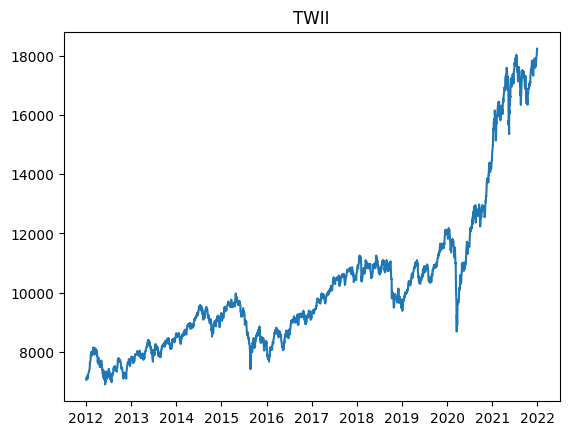

In [ ]:
!pip install statsmodels -q
!pip install arch -q
!pip install pmdarima -q
!pip install mgarch -q

from google.colab import drive
drive.mount("/content/drive")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

ticker = "^TWII"
start_date = "1998-01-01"
end_date = "2022-01-01"
data_all = yf.download(ticker, start=start_date, end=end_date)
plt.title("TWII")
plt.plot(data_all["Close"][-2441:])
plt.savefig("price_time.png")

In [ ]:
start_date = "2022-01-01"
end_date = "2023-07-01"
data_test_all = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


# Data preprocessing

## 1-th item in real_part is trend, we extract it out

In [ ]:
def FFT_M_norolling(period, num):
  empty1 = []
  for i in range(len(period)//(num)):
    FFT_result = np.fft.fft(period[i*(num) : (i + 1)*(num)])
    empty1.append(FFT_result)
  empty1 = pd.DataFrame(empty1)
  return empty1

close = data_all["Close"][-2441:]
close_test = data_test_all["Close"]

windows = 20
Xk_no_rolling = FFT_M_norolling(close, windows)
real = np.real(Xk_no_rolling)
imag = np.imag(Xk_no_rolling)
X_test = FFT_M_norolling(close_test, windows)
real_test = np.real(X_test)
imag_test = np.imag(X_test)

if windows % 2 == 0:
  data = [real[:,:windows//2+1], imag[:,:windows//2+1]]
  data_test = [real_test[:,:windows//2+1], imag_test[:,:windows//2+1]]
else:
  data = [real[:,:windows//2], imag[:,:windows//2]]
  data_test = [real_test[:,:windows//2], imag_test[:,:windows//2]]

oned_data = data[0][:,0]
data = [data[0][:,1:], data[1][:,1:]]
print(data[0].shape, data[1].shape)
print(data_test[0].shape, data_test[1].shape)

(122, 10) (122, 10)
(17, 11) (17, 11)


### Using the Augmented Dickey-Fuller (ADF) test, we individually assessed the stationarity of 20 time series data.
When the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(data, sig):

  '''
  data : list : [real_part, imag_part]; real_part and imag_part is nparray, shape like (time points, number of time series data)
  sig : significance level
  '''

  real_non = {}
  imag_non = {}
  print("=====ADF TEST=====")
  print("real part", " ", "imag part")
  print("===================")
  for i in range(data[0].shape[1]):
    print("%d"%i)
    print('--')
    print(adfuller(data[0][:,i])[0]<adfuller(data[0][:,i])[4]["%d%%"%sig], "     ", adfuller(data[1][:,i])[0]<adfuller(data[1][:,i])[4]["%d%%"%sig])
    print("------------------")
    if (adfuller(data[0][:,i])[0]<adfuller(data[0][:,i])[4]["%d%%"%sig]) == False:
      real_non[i] = data[0][:,i]
    if (adfuller(data[1][:,i])[0]<adfuller(data[0][:,i])[4]["%d%%"%sig]) == False:
      imag_non[i] = data[1][:,i]

  return real_non, imag_non

real_non, imag_non = ADF_test(data, 1)

=====ADF TEST=====
real part   imag part
0
--
True       True
------------------
1
--
True       True
------------------
2
--
True       True
------------------
3
--
True       False
------------------
4
--
True       True
------------------
5
--
True       True
------------------
6
--
True       True
------------------
7
--
True       True
------------------
8
--
True       True
------------------
9
--
True       True
------------------


In [ ]:
real_non.keys(), imag_non.keys()

(dict_keys([]), dict_keys([3]))

## Transforming two nonstationary data to stationary by first-differencing

In [ ]:
data[0].shape

(122, 10)

In [ ]:
diff = 1

for i in range(1,2):
  for j in range(data[i].shape[1]):
    filled_array = np.insert(data[i][:,j], 0, data[i][:,j][0])
    data[i][:,j] = np.diff(filled_array, n = diff)

In [ ]:
data[0].shape, data[1].shape

((122, 10), (122, 10))

In [ ]:
# diff = 1
# for i in real_non.keys():
#   filled_array = np.insert(real_non[i], 0, real_non[i][0])
#   data[0][:,i] = np.diff(filled_array, n = diff)
#   print(adfuller(data[0][:,i])[0]<adfuller(data[0][:,i])[4]["1%"])

# for i in imag_non.keys():
#   if i != 0:
#     filled_array = np.insert(imag_non[i], 0, imag_non[i][0])
#     data[1][:,i] = np.diff(filled_array, n = diff)
#     print(adfuller(data[1][:,i])[0]<adfuller(data[0][:,i])[4]["1%"])

# ADF_test(data, 1)

=====ADF TEST=====
real part   imag part
0
--
True       True
------------------
1
--
True       True
------------------
2
--
True       True
------------------
3
--
True       True
------------------
4
--
True       True
------------------
5
--
True       True
------------------
6
--
True       True
------------------
7
--
True       True
------------------
8
--
True       True
------------------
9
--
True       True
------------------


({}, {})

## Now, we take the first term (zeroes) and the last term (different scale) in imag_part out. Thus, we build ARIMA_1 for 10-th data in image part.

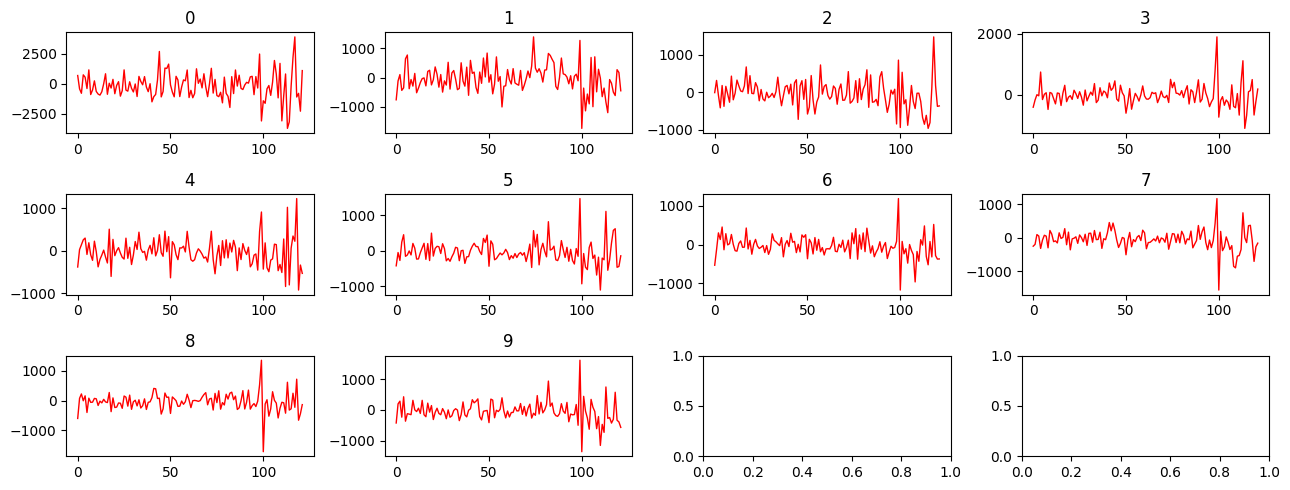

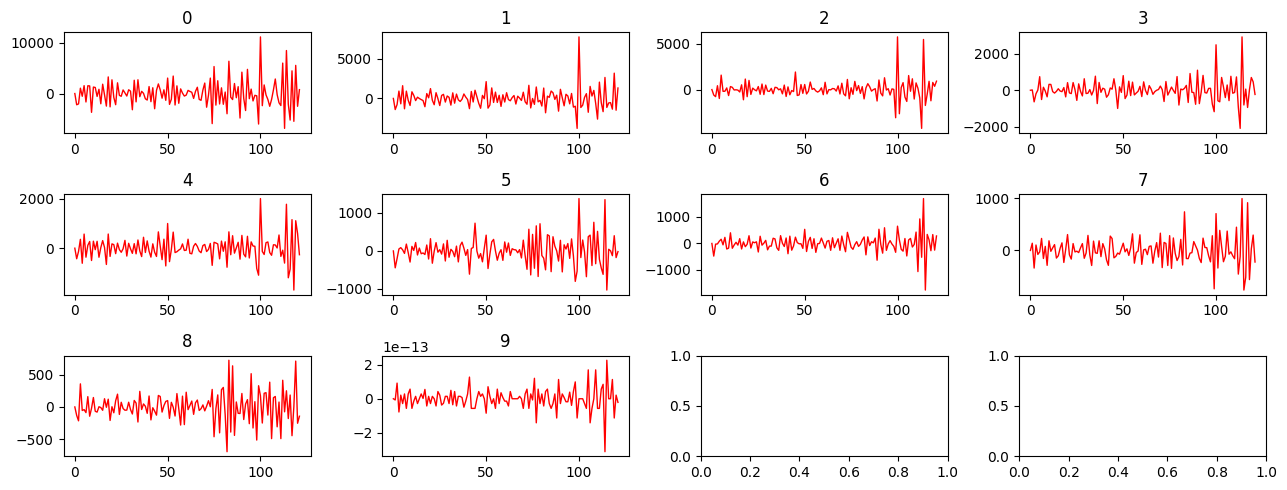

In [ ]:
data_sta = [data[0], data[1]]
for j in range(2):
  fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(13,5))
  for i, ax in enumerate(axes.flatten()):
    try:
      ax.plot(data_sta[j][:,i], color='red', linewidth=1)
      ax.set_title("%d"%i)
    except:
      pass
  plt.tight_layout();

## determine which data are appropriate to use VAR model by Granger Causality test
Null Hypothesis (H0): Time series x does not Granger-cause time series y

Alternative Hypothesis (HA): Time series x Granger-causes time series y

If the $\textbf{p-value is less than a certain significance level (i.e. α = .05), then we can reject the null hypothesis}$ and conclude that we have sufficient evidence to say that time series x Granger-causes time series y.

Question1 : 多少個被拒絕我們才會認為他沒辦法預測其他的資料，另外，挑出來另外建模的結果有理論證明他會更好嗎

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

def GC_test(data, max_lag, sig):

  '''
  data : list : [real_part, imag_part]; real_part and imag_part is nparray, shape like (time points, number of time series data)
  max_lag : same as https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html

  return : NaN means that p-value is greater than or equal to sig
  '''

  df_data = [pd.DataFrame(data[0]), pd.DataFrame(data[1])]
  test = 'ssr_chi2test'
  df_pvalue = []

  for i in range(2):
    df_pvalue_temp = pd.DataFrame(np.zeros((len(df_data[i].columns), len(df_data[i].columns))),
                            columns = df_data[i].columns,
                            index = df_data[i].columns)
    for col in range(len(df_data[i].columns)):
      for col_ in range(len(df_data[i].columns)):
        gc_res = grangercausalitytests(df_data[i][[col,col_]], max_lag, verbose=False)
        p_values = [round(gc_res[j+1][0][test][1],4) for j in range(max_lag)]
        min_pvalue = np.min(p_values)
        df_pvalue_temp.loc[col, col_] = min_pvalue
    df_pvalue.append(df_pvalue_temp)

  df_pvalue[0] = df_pvalue[0][df_pvalue[0]<sig]
  df_pvalue[1] = df_pvalue[1][df_pvalue[1]<sig]

  return df_pvalue

max_lag = 12
sig = 0.05
df_pvalue = GC_test(data_sta, max_lag, sig)

In [ ]:
df_pvalue[0]

,0,1,2,3,4,5,6,7,8,9
0,NaN,NaN,NaN,0.0014,NaN,NaN,NaN,NaN,NaN,0.0055
1,0.0029,NaN,0.0028,0.0046,NaN,0.0076,0.0034,0.0117,NaN,0.0003
2,0.0065,NaN,NaN,NaN,NaN,0.0065,0.0032,0.0027,NaN,0.0006
3,0.0000,0.0182,0.0017,NaN,NaN,0.0115,0.0001,0.0002,0.0006,0.0000
4,0.0001,NaN,0.0071,0.0010,NaN,NaN,0.0402,0.0055,NaN,0.0448
5,0.0010,0.0230,0.0033,0.0000,NaN,NaN,0.0065,0.0331,0.0004,0.0002
6,NaN,NaN,NaN,0.0000,0.0094,0.0053,NaN,NaN,0.0114,0.0000
7,0.0000,0.0338,0.0000,0.0000,0.0008,0.0011,0.0437,NaN,0.0089,0.0000
8,0.0048,0.0469,0.0079,0.0000,0.0205,0.0009,0.0100,NaN,NaN,0.0008
9,0.0053,0.0002,NaN,0.0000,NaN,0.0047,0.0002,0.0001,0.0089,NaN


In [ ]:
df_pvalue[1]

,0,1,2,3,4,5,6,7,8,9
0,NaN,0.0005,NaN,0.0025,0.0067,0.0003,0.0477,NaN,0.0016,NaN
1,0.0088,NaN,NaN,0.0035,0.0288,0.0052,0.0164,NaN,0.0023,NaN
2,0.0002,0.0469,NaN,0.0014,0.0054,0.0000,0.0012,NaN,0.0031,NaN
3,0.0006,0.0018,NaN,NaN,NaN,0.0000,0.0000,NaN,0.0358,NaN
4,0.0001,0.0107,0.0028,0.0049,NaN,0.0005,0.0497,0.0012,0.0001,NaN
5,0.0009,0.0008,0.0000,0.0138,0.0356,NaN,0.0000,0.0344,NaN,NaN
6,NaN,0.0004,0.0077,0.0010,NaN,0.0266,NaN,0.0175,0.0029,NaN
7,0.0000,0.0020,0.0000,0.0451,NaN,NaN,0.0083,NaN,NaN,NaN
8,0.0001,0.0010,0.0122,NaN,0.0001,NaN,0.0228,0.0000,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
VAR_data1 = data_sta[0]
VAR_data2 = data_sta[1][:-1]
oned_data2 = data_sta[1][-1]
oned_true = data_test[0][:,0]
true_data = close_test

# Model

# ARIMA & AR
passing test, we take AR(1) as the model of data of small scale

### ARIMA

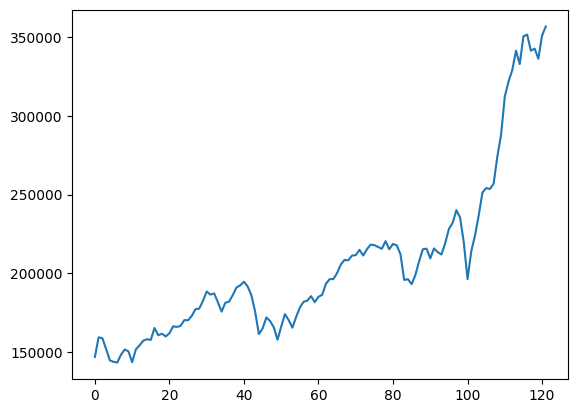

In [ ]:
plt.plot(oned_data)

In [ ]:
import statsmodels.api as sm
from pmdarima import auto_arima

def cho_SARIMA(data,p,d,q,Sp,Sd,Sq):

  best_aic = float("inf")
  best_params = None

  for p in range(p):  # 自回歸（AR）的階數
    for d in range(d):  # 差分（I）的階數
      for q in range(q):  # 移動平均（MA）的階數
        for P in range(Sp):  # 季節性自回歸（SAR）的階數
          for D in range(Sd):  # 季節性差分（SI）的階數
            for Q in range(Sq):  # 季節性移動平均（SMA）的階數
              try:
                # 創建SARIMAX模型
                order = (p, d, q)
                seasonal_order = (P, D, Q, 12)  # 假設季節週期為12
                model = sm.tsa.SARIMAX(data, order=order, seasonal_order=seasonal_order)
                model_fit = model.fit()

                # 計算AIC值
                aic = model_fit.aic

                # 更新最佳參數和最小AIC值
                if aic < best_aic:
                  best_aic = aic
                  best_params = (order, seasonal_order)
                  best_model = model_fit
              except:
                continue

  # 打印最佳參數和最小AIC值
  print("Best AIC:", best_aic)
  print("Best Parameters:", best_params)

  return best_model


model = auto_arima(oned_data, starseasonal = True, m = 4, suppress_warnings=True)
# model = cho_SARIMA(oned_data,3,3,3,3,3,3)

#### Ljung-Box test of autocorrelation of residuals.
If the p-value is less than the chosen significance level, we can reject the null hypothesis, indicating that the residual sequence exhibits autocorrelation.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


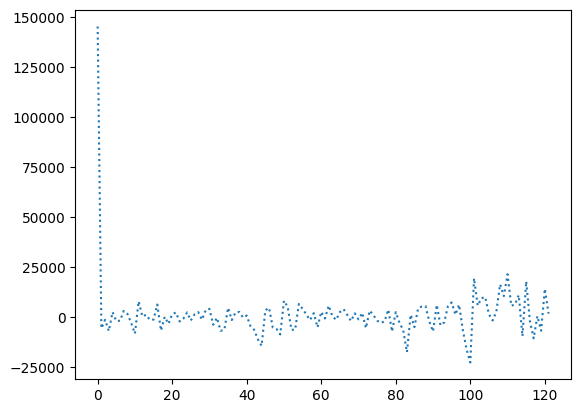

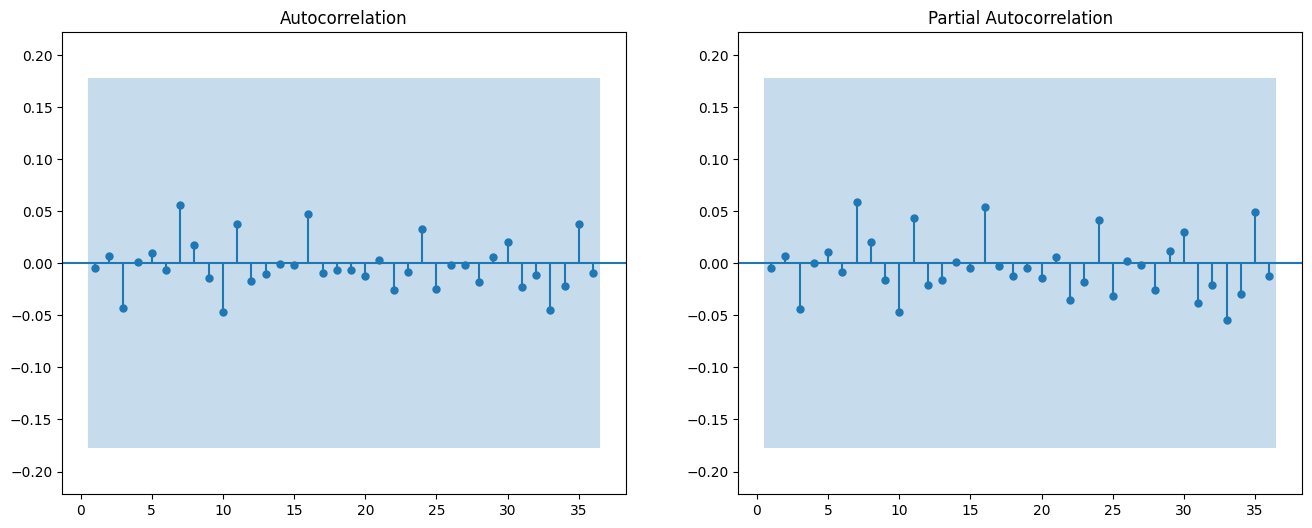

     lb_stat  lb_pvalue
1   0.002741   0.958250
2   0.008939   0.995540
3   0.244128   0.970169
4   0.244299   0.993120
5   0.257574   0.998366
6   0.262837   0.999657
7   0.672474   0.998538
8   0.712312   0.999495
9   0.737335   0.999841
10  1.031277   0.999802
11  1.223640   0.999861
12  1.264843   0.999948


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

oned_resi = model.resid()
plt.plot(np.arange(len(oned_resi)), oned_resi, linestyle="dotted")

fig, ax = plt.subplots(1, 2, figsize=(16,6))
plot_acf(oned_resi, ax=ax[0], lags=36, zero = False, auto_ylims = True, bartlett_confint = False)
plot_pacf(oned_resi, ax=ax[1], lags=36, zero = False, auto_ylims = True)
plt.show()

print(acorr_ljungbox(oned_resi, lags = 12))

In [ ]:
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  122
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 4)   Log Likelihood               -1238.728
Date:                           Thu, 15 Jun 2023   AIC                           2485.457
Time:                                   09:03:45   BIC                           2496.640
Sample:                                        0   HQIC                          2489.999
                                           - 122                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1449.9972    671.475      2.159      0.031     133.930    2766.065
ma.L1          0.1181      0.045      2.626

## No normal

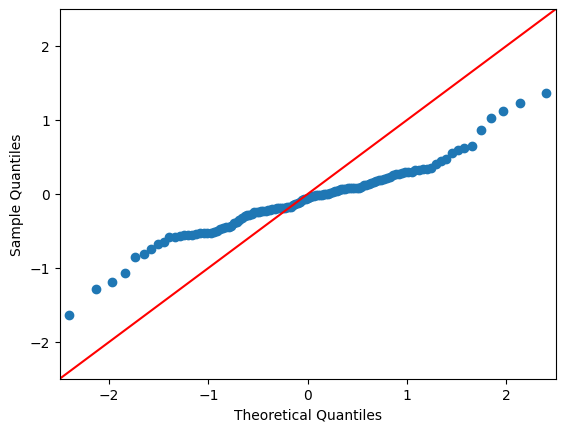

In [ ]:
from scipy.stats import kstest

norm_oned_resi = (oned_resi - np.mean(oned_resi)) / np.std(oned_resi)
sm.qqplot(norm_oned_resi[1:], line = '45')
plt.show()


kstest(oned_resi[1:], 'norm')

KstestResult(statistic=0.5289256198347108, pvalue=4.22527031404903e-32, statistic_location=196.7568543641246, statistic_sign=-1)

## AR

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(oned_data, lags = 1).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  122
Model:                     AutoReg(1)   Log Likelihood               -1242.360
Method:               Conditional MLE   S.D. of innovations           6963.960
Date:                Tue, 13 Jun 2023   AIC                           2490.721
Time:                        12:13:32   BIC                           2499.108
Sample:                             1   HQIC                          2494.127
                                  122                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2657.2896   2615.638     -1.016      0.310   -7783.846    2469.267
y.L1           1.0215      0.012     82.281      0.000       0.997       1.046
                                    Roots           

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


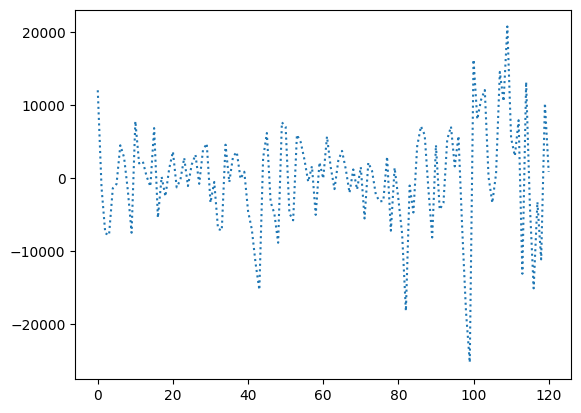

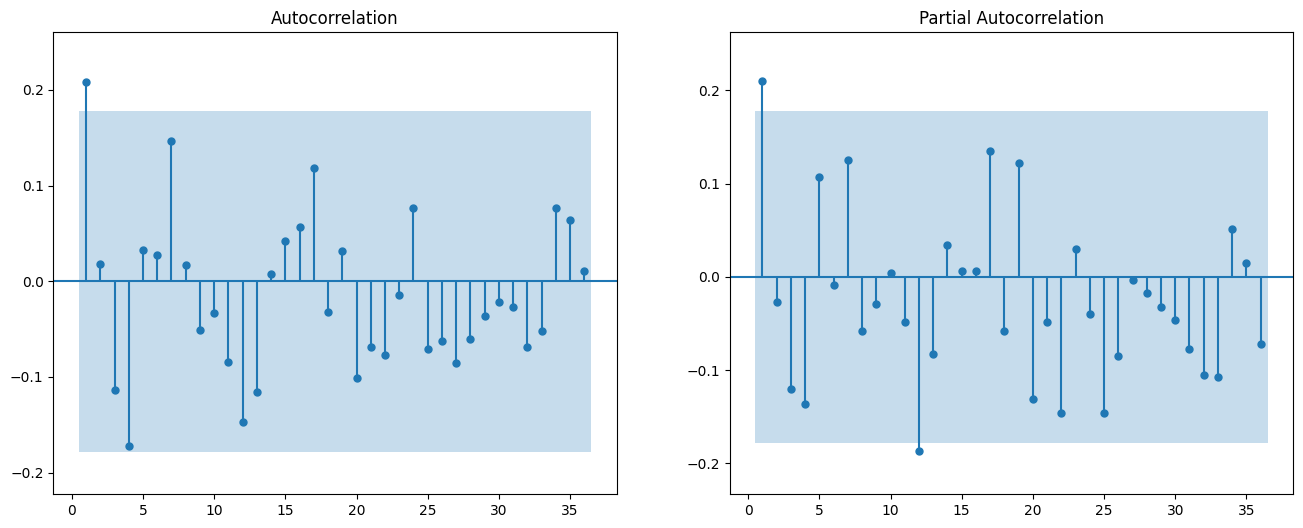

      lb_stat  lb_pvalue
1    5.377434   0.020399
2    5.416009   0.066670
3    7.038726   0.070674
4   10.821584   0.028644
5   10.955770   0.052264
6   11.049646   0.086854
7   13.866398   0.053609
8   13.902478   0.084343
9   14.242280   0.113964
10  14.390289   0.155922
11  15.347705   0.167126
12  18.305033   0.106738


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

oned_resi = model.resid
plt.plot(np.arange(len(oned_resi)), oned_resi, linestyle="dotted")

fig, ax = plt.subplots(1, 2, figsize=(16,6))
plot_acf(oned_resi, ax=ax[0], lags=36, zero = False, auto_ylims = True, bartlett_confint = False)
plot_pacf(oned_resi, ax=ax[1], lags=36, zero = False, auto_ylims = True)
plt.show()

print(acorr_ljungbox(oned_resi, lags = 12))

## predicted result with AR(1)

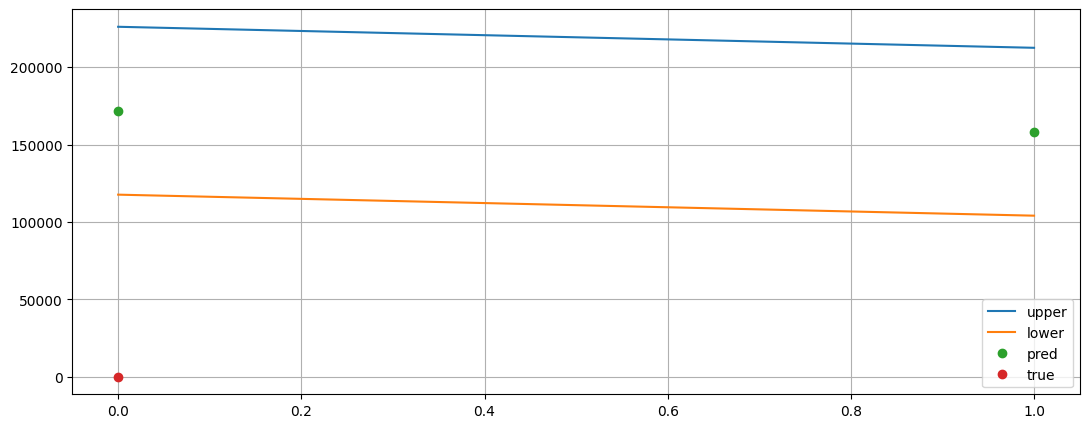

In [ ]:
step = 2

start = 1  # 預測起始索引
end = step  # 預測結束索引
pred = model.get_prediction(start=start, end=end)

oned_pred_ = pred.predicted_mean
conf_pred = pred.conf_int()
fig, ax = plt.subplots(1, 1, figsize=(13,5))
plt.plot(conf_pred[1:,1])
plt.plot(conf_pred[1:,0])
plt.plot(oned_pred_[1:], 'o')
plt.plot(oned_true[:step-1], 'o')
plt.legend(["upper", "lower", "pred", "true"])
plt.grid()
plt.show()

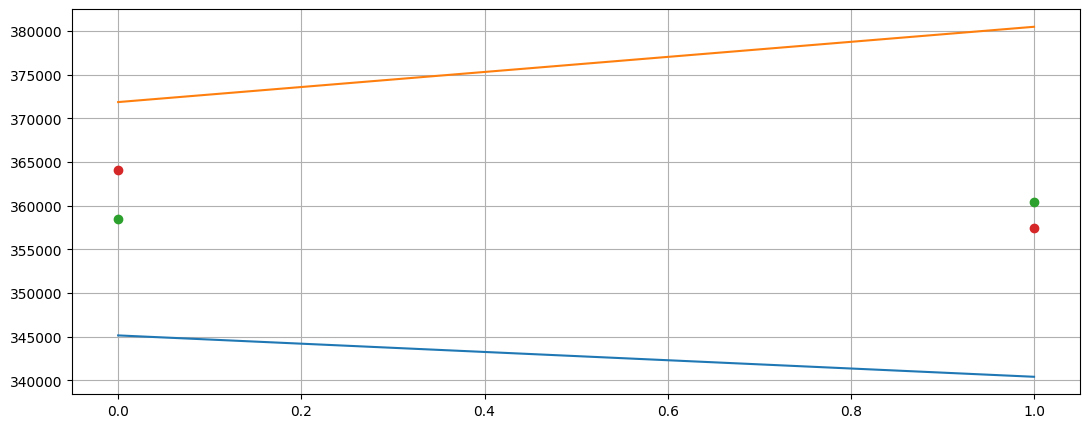

In [ ]:
step = 2

start = 1
end = step
pred, conf_int = model.predict(n_periods=2, return_conf_int=True)

fig, ax = plt.subplots(1, 1, figsize=(13,5))
plt.plot(conf_int[:,0])
plt.plot(conf_int[:,1])
plt.plot(pred, 'o')
plt.plot(oned_true[:step], 'o')
plt.grid()
plt.show()

# VAR_1 & VAR_2

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR

VAR_data = [VAR_data1, VAR_data2]
res = []

for i in range(2):
  print("====================================")
  mod = VAR(VAR_data[i])
  res.append(mod.fit(ic='aic'))
  print(res[i].summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, Jun, 2023
Time:                     08:21:25
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    117.389
Nobs:                     112.000    HQIC:                   102.821
Log likelihood:          -5780.16    FPE:                2.35386e+45
AIC:                      92.8741    Det(Omega_mle):     3.80334e+42
--------------------------------------------------------------------
Results for equation y1
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -5.217817        99.225143           -0.053           0.958
L1.y1          -0.793934         0.399852           -1.986           0.047
L1.y2          -0.565129         0.939269           -0.602           0.547
L1.y3       

### Ljung-Box Statistic:

0 : 0.97072
1 : 0.16277
2 : 0.01374 bad!
3 : 0.06256
4 : 0.16177
5 : 0.00000 bad!
6 : 0.13921
7 : 0.03698 bad!
8 : 0.07498
9 : 0.00000 bad!
0 : 0.00007 bad!
1 : 0.00067 bad!
2 : 0.05121
3 : 0.06055
4 : 0.03013 bad!
5 : 0.56946
6 : 0.42218
7 : 0.00145 bad!
8 : 0.79251
9 : 0.00005 bad!


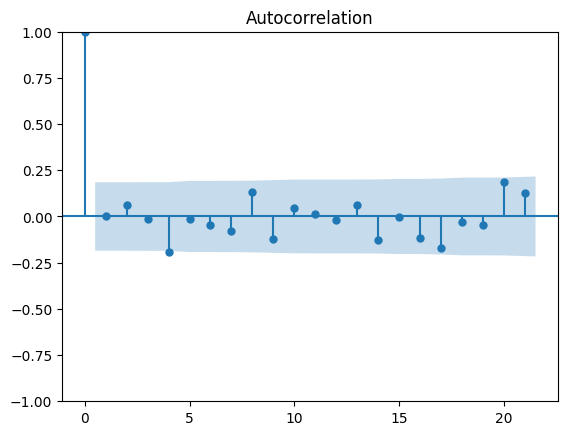

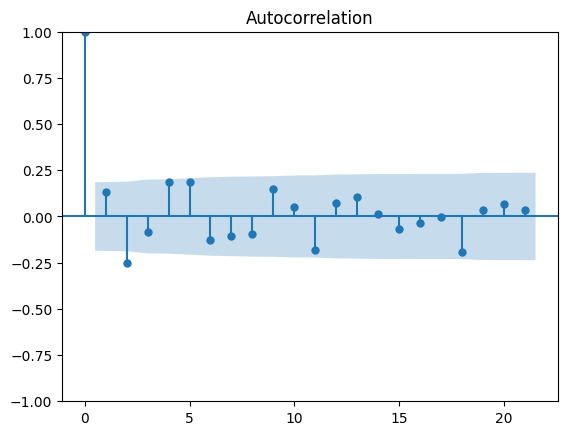

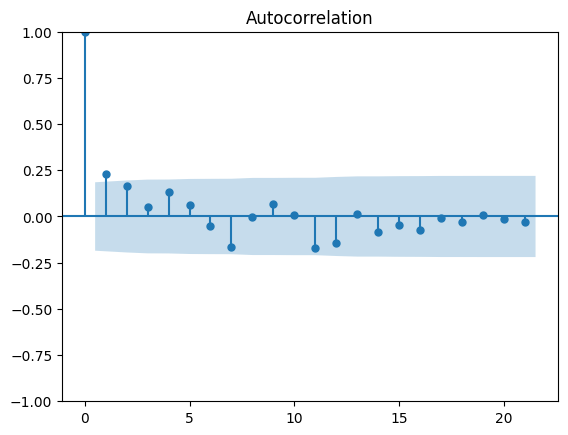

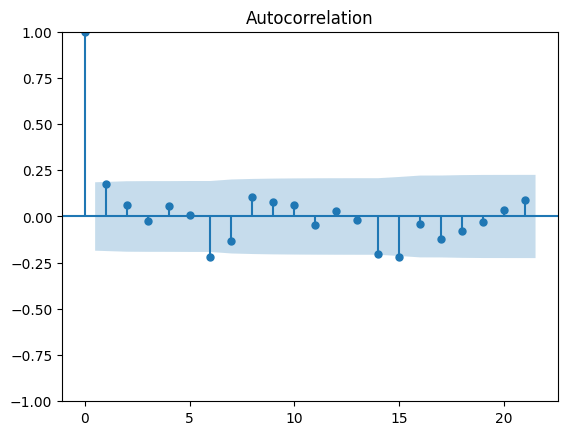

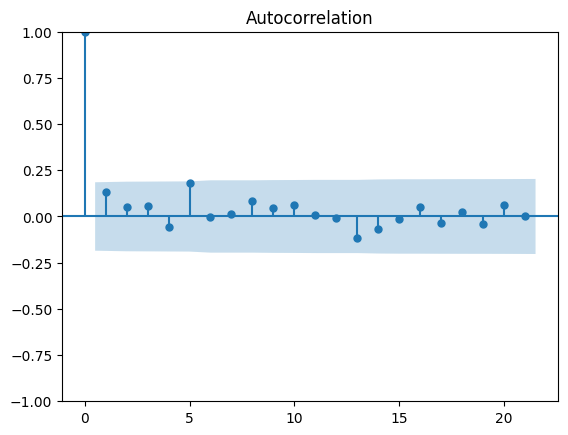

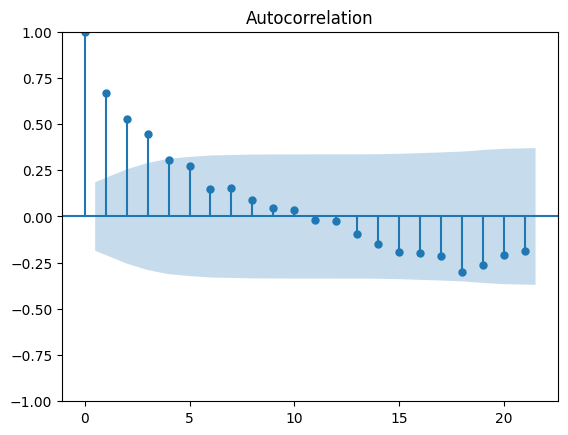

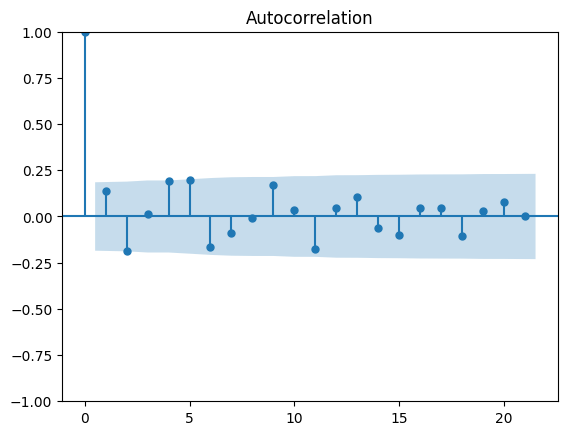

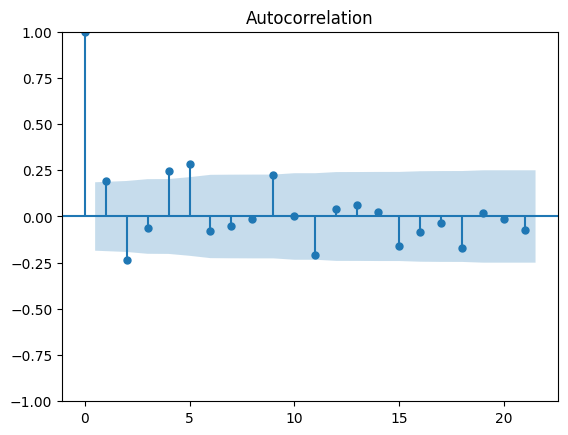

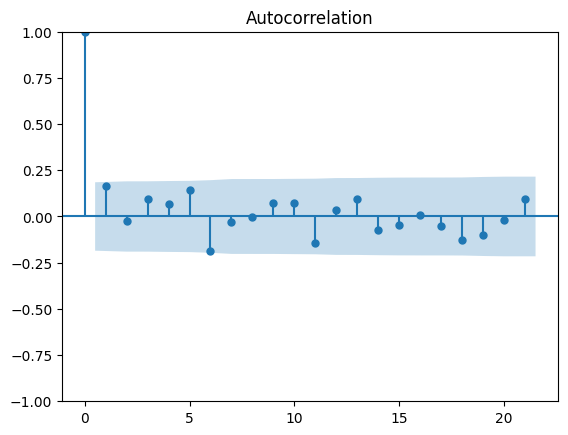

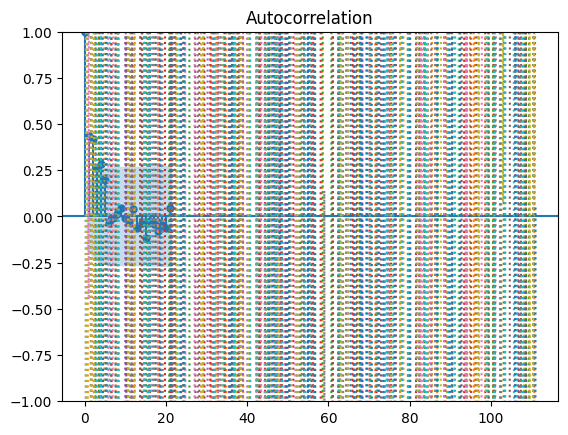

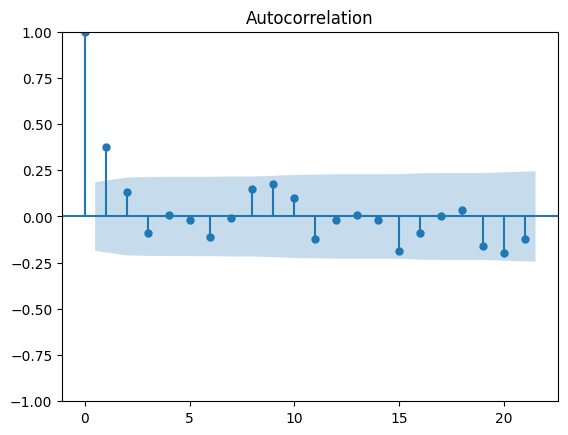

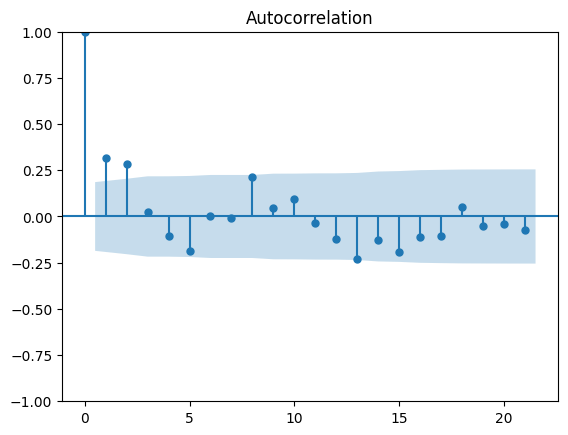

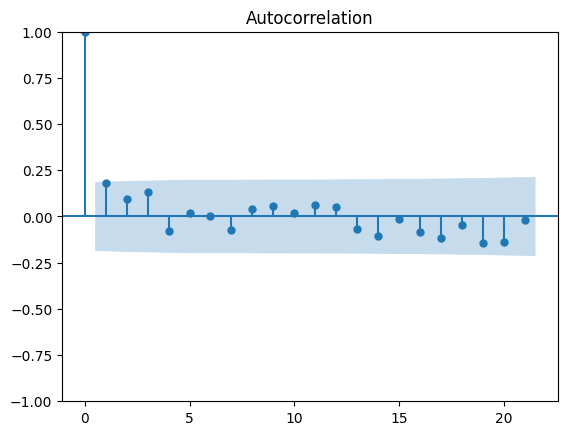

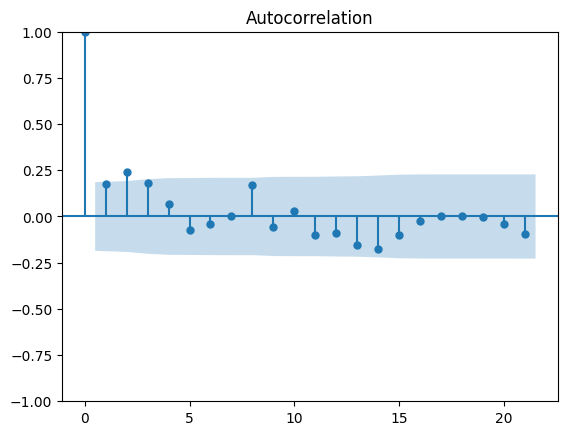

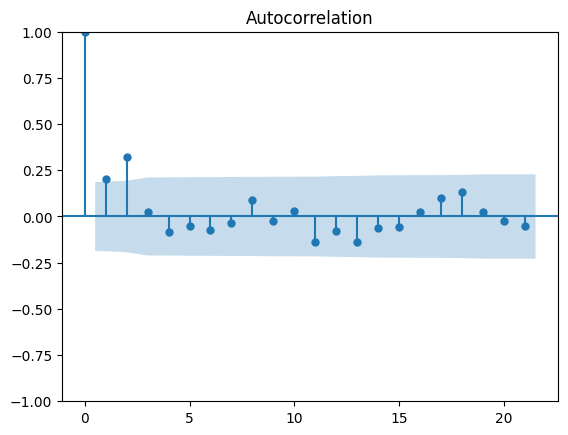

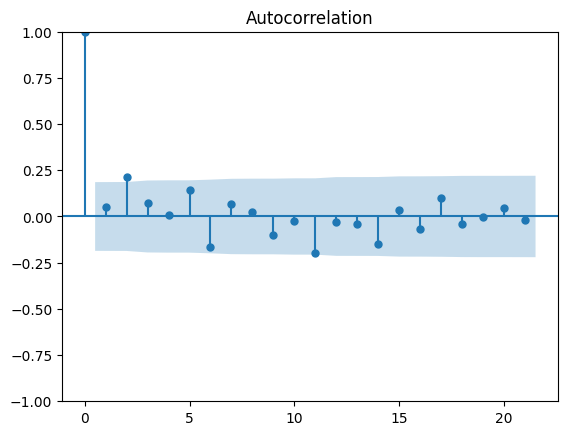

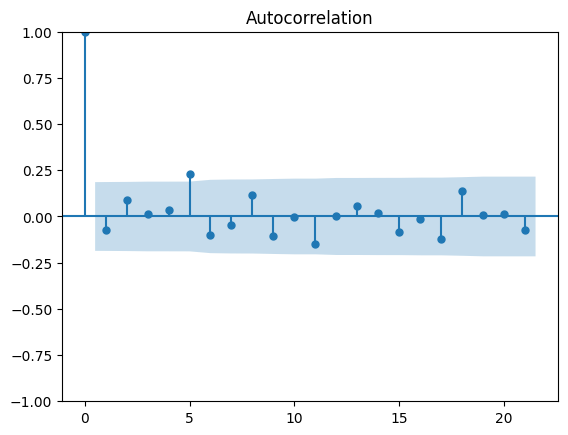

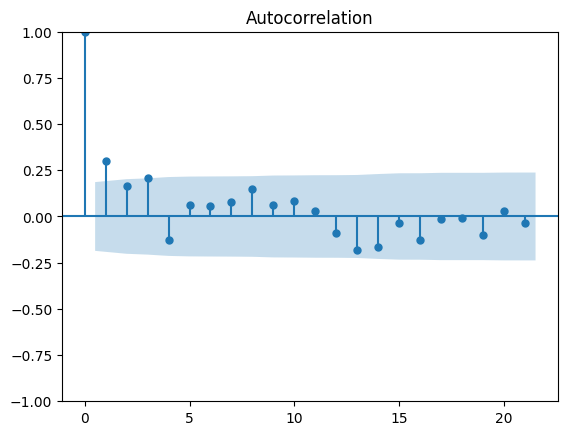

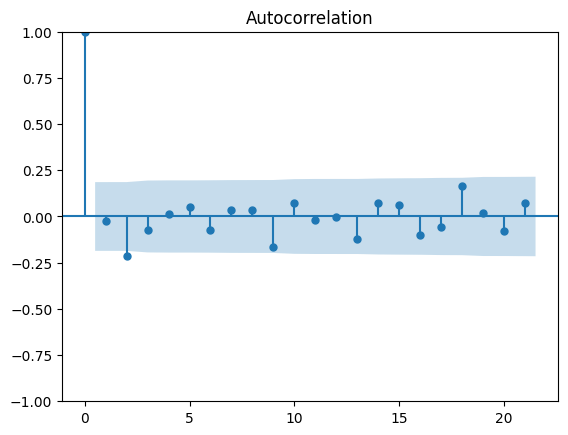

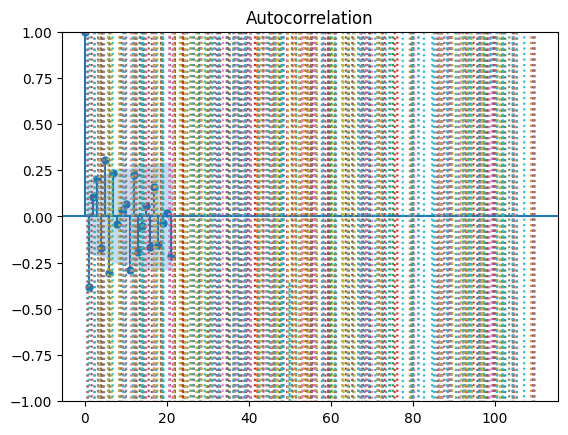

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lag = 1
for i in range(2):
  print("===============================")
  residual = res[i].resid
  for j in range(residual.shape[1]):
    plot_acf(residual[:,j])
  plt.plot(np.arange(len(residual)), residual, linestyle="dotted")

  out = [acorr_ljungbox(residual[:,j])['lb_pvalue'][lag] for j in range(residual.shape[1])]

  for col, val in zip(np.array([i for i in range(len(VAR_data[i]))]), out):
    if val < 0.05:
      print("%d : %.5f" % (col, val), 'bad!')
    else:
      print("%d : %.5f" % (col, val))

In [ ]:
def imag_part_predict(part3_model, input, step):
  part3_lag = part3_model.k_ar
  part3_predict = part3_model.forecast(y = input[-part3_lag:], steps = step)
  temp = np.zeros((part3_predict.shape[0])).reshape(-1,1)
  result = np.concatenate([part3_predict[:,:],temp], axis = 1)
  result = np.concatenate([result,-1*(part3_predict[:,::-1])], axis = 1)
  result = np.concatenate([temp, result], axis = 1)
  return result

def real_close_pred(part1_model, part2_model, part3_model, part_2, part_3, step):
  real_predict = real_part_predict(part1_model, part2_model, part_2, step)
  imag_predict = imag_part_predict(part3_model, part_3, step)
  predict_xk = real_predict + imag_predict * 1j
  predict_close = np.real(fft.ifft(predict_xk))
  predict = predict_close.reshape(-1,)
  return predict

def real_close_pred_garch(part1_model, part2_model, part3_model, part2, part3, step):
  real_predict = real_part_predict_garch(part1_model, part2_model, part2, step)
  imag_predict = imag_part_predict(part3_model, part3, step)
  predict_xk = real_predict + imag_predict * 1j
  predict_close = np.real(fft.ifft(predict_xk))
  predict = predict_close.reshape(-1,)
  return predict

In [ ]:
predict_2 = real_close_pred(arima, part2_var, part3_var, part2, part3, 1)
predict_s = real_close_pred(sarima, part2_var, part3_var, part2, part3, 2)

In [ ]:
predict_2_garch = real_close_pred_garch(arima, part2_var, part3_var, part2, part3, 2)
predict_s_garch = real_close_pred_garch(sarima, part2_var, part3_var, part2, part3, 1)

In [ ]:
plt.plot(predict_2, label = 'ARIMA + VAR',linestyle = '-.')
plt.plot(predict_s, label = 'SARIMA + VAR', linestyle = '--')
# plt.axhline(np.mean(predict_close[0][1:]))
plt.plot(close_test[:1*20], label = 'real')
# plt.axhline(np.mean(close_test[:20]))
plt.legend()
plt.show()

In [ ]:
plt.plot(predict_2_garch, label = 'ARIMA-GARCH(1,1) + VAR',linestyle = '-.')
plt.plot(predict_s, label = 'SARIMA + VAR', linestyle = '--')
# plt.axhline(np.mean(predict_close[0][1:]))
plt.plot(close_test[:2*20], label = 'real')
# plt.axhline(np.mean(close_test[:20]))
plt.legend()
plt.show()

# Johansen test (Supplement; No use in here)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.vector_ar.vecm import coint_johansen


def joh_output(res):
  output = pd.DataFrame([res.lr2,res.lr1], index=['max_eig_stat',"trace_stat"])
  print(output.T,'\n')
  print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
  print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

# 避免再 Johensen test 出現 singular matrix

# 先對資料做PCA
def pca(data, thd):
  data_comp = []
  for i in data:
    dat = i
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dat)
    pca = PCA()
    data_pca = pca.fit_transform(data_scaled)
    exp_var_ratio = pca.explained_variance_ratio_
    num=0
    for j in range(len(exp_var_ratio)):
      num+=exp_var_ratio[j]
      if num > thd:
        data_comp.append(j)
        break
  return data_comp

# data_comp = pca(data_VAR, 0.9)
# data_pca = []
# for i in range(2):
#   pca = PCA(n_components=data_comp[i]+1)
#   data_pca.append(pca.fit_transform(data_VAR[i]))

# 這裡不能降維，希望透過不降維去除共線性的方法

data_pca = data_VAR
# Johensen test
Jhs_test = []
for i in range(2):
  print("========================================================")
  result = coint_johansen(data_pca[i], det_order=0, k_ar_diff=1)
  Jhs_test.append(result)
  joh_output(result)

In [ ]:
import numpy as np


A = np.corrcoef(data_VAR[0], rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(A)

In [ ]:
print(eigenvalues, eigenvectors)

In [ ]:
eigenvectors @ np.diag(eigenvalues) @ np.linalg.inv(eigenvectors)

## 解讀 Johensen test
1, 彼此間是否有協整姓 (cointegration)


In [ ]:
reject_all = []
reject_met = []
reject_ts = []
for i in range(2):
  ra = []
  rm = []
  rt = []
  print("================================")
  for j in range(len(Jhs_test[i].cvm)):
    if Jhs_test[i].lr1[j] > Jhs_test[i].cvm[j,1] and Jhs_test[i].lr2[j] > Jhs_test[i].cvt[j,1]:
      ra.append(j)
    elif Jhs_test[i].lr1[j] > Jhs_test[i].cvm[j,1] and Jhs_test[i].lr2[j] < Jhs_test[i].cvt[j,1]:
      rm.append(j)
    elif Jhs_test[i].lr1[j] < Jhs_test[i].cvm[j,1] and Jhs_test[i].lr2[j] > Jhs_test[i].cvt[j,1]:
      rt.append(j)
    else:
      print("%d-th is not good"%j)

  reject_all.append(ra)
  reject_met.append(rm)
  reject_ts.append(rt)
  print(reject_all[i], reject_met[i], reject_ts[i])

## 找出具有協整性的線性組合係數

In [ ]:
from statsmodels.tsa.vector_ar.vecm import VECM

coef = []
intercept = []
for i in range(2):
  model = VECM(data_pca[i][:,reject_all[i]], k_ar_diff=1)
  res = model.fit()
  coef.append(res.alpha)
  intercept.append(res.beta)

print(coef[0], coef[1])
plt.subplot(121)
plt.plot(data_pca[0][:,reject_all[0]] @ coef[0])
plt.subplot(122)
plt.plot(data_pca[1][:,reject_all[1]] @ coef[1])
plt.show()

In [ ]:
data_pca[0][:,reject_all[0]][0]

In [ ]:
pred_steps = 5

last_observation = data_pca[i][:,reject_all[i]][-1]

# 建立一個用於存儲預測結果的空陣列
forecast = np.zeros((forecast_steps, X.shape[1]))

# 進行多步預測
for i in range(forecast_steps):
    # 計算預測值
    forecast[i] = intercept + np.dot(coefs, last_observation)

    # 更新預測起點
    last_observation = forecast[i]

# 輸出預測結果
print("Forecast:")
print(forecast)